In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tensorflow as tf
from transformers import BertTokenizer
from transformers import TFBertModel
from gluonnlp.data import SentencepieceTokenizer
#  # 자꾸 오류가 남

In [2]:
!pip install gluonnlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp310-cp310-linux_x86_64.whl size=661772 sha256=dd95d8a2bb9f02f2f6bab893488b6003e3bda44b601e7462fb30e4217c704597
  Stored in directory: /root/.cache/pip/wheels/1a/1e/0d/99f55911d90f2b95b9f7c176d5813ef3622894a4b30fde6bd3
Successfully built gluonnlp


In [4]:
!pip install mxnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 20.0 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


In [8]:
!pip install mxnet-mkl==1.6.0 numpy==1.19.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 21.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!cd /content/drive/MyDrive/toy_project/Bert

In [4]:
data_path = '/content/drive/MyDrive/toy_project/Bert'
train_sts = os.path.join(data_path, 'korSTS', 'sts-train.tsv')
train_data = pd.read_csv(train_sts, sep='\t', quoting=3)
train_data.head(10)

,genre,filename,year,id,score,sentence1,sentence2
0,main-captions,MSRvid,2012test,1,5.00,비행기가 이륙하고 있다.,비행기가 이륙하고 있다.
1,main-captions,MSRvid,2012test,4,3.80,한 남자가 큰 플루트를 연주하고 있다.,남자가 플루트를 연주하고 있다.
2,main-captions,MSRvid,2012test,5,3.80,한 남자가 피자에 치즈를 뿌려놓고 있다.,한 남자가 구운 피자에 치즈 조각을 뿌려놓고 있다.
3,main-captions,MSRvid,2012test,6,2.60,세 남자가 체스를 하고 있다.,두 남자가 체스를 하고 있다.
4,main-captions,MSRvid,2012test,9,4.25,한 남자가 첼로를 연주하고 있다.,자리에 앉은 남자가 첼로를 연주하고 있다.
5,main-captions,MSRvid,2012test,11,4.25,몇몇 남자들이 싸우고 있다.,두 남자가 싸우고 있다.
6,main-captions,MSRvid,2012test,12,0.50,남자가 담배를 피우고 있다.,남자가 스케이트를 타고 있다.
7,main-captions,MSRvid,2012test,13,1.60,남자가 피아노를 치고 있다.,남자가 기타를 연주하고 있다.
8,main-captions,MSRvid,2012test,14,2.20,한 남자가 기타를 치고 노래를 부르고 있다.,한 여성이 어쿠스틱 기타를 연주하고 노래를 부르고 있다.
9,main-captions,MSRvid,2012test,16,5.00,사람이 고양이를 천장에 던지고 있다.,사람이 고양이를 천장에 던진다.


점수는 0에서 5점까지 있고 두 문장의 유사도를 기준으로 하여 비슷한지를 회귀하는 것이다.

In [16]:
print('전체 train_data 개수: {}'.format(len(train_data)))

전체 train_data 개수: 5749


In [5]:
train_set = pd.Series(train_data['sentence1'].tolist() + train_data['sentence2'].tolist()).astype(str)
print('전체 문장 데이터의 개수: {}'.format(len(train_set)))
print('유일한 총 문장 수 : {}'.format(len(train_set)))
print('반복해서 나타나는 문장의 수 : {}'.format(np.sum(train_set.value_counts() > 1)))

전체 문장 데이터의 개수: 11498
유일한 총 문장 수 : 11498
반복해서 나타나는 문장의 수 : 716


Text(0, 0.5, 'Number of sentence')

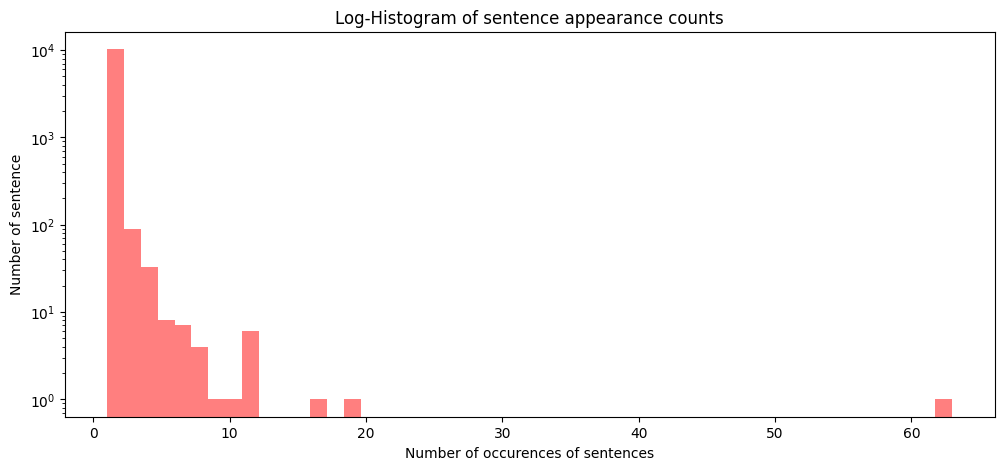

In [6]:
plt.figure(figsize=(12, 5))
plt.hist(train_set.value_counts(), bins=50, alpha=0.5, color='r', label='word')
plt.yscale('log')
plt.title('Log-Histogram of sentence appearance counts')
plt.xlabel('Number of occurences of sentences')
plt.ylabel('Number of sentence')

In [26]:
print('중복 최대 개수: {}'.format(np.max(train_set.value_counts())))
print('중복 최소 개수: {}'.format(np.min(train_set.value_counts())))
print('중복 평균 개수: {:.2f}'.format(np.mean(train_set.value_counts())))
print('중복 표준편차: {}'.format(np.std(train_set.value_counts())))
print('중복 중간길이: {}'.format(np.median(train_set.value_counts())))
print('제1사분위 중복: {}'.format(np.percentile(train_set.value_counts(), 25)))
print('제4사분위 중복: {}'.format(np.percentile(train_set.value_counts(), 75)))

중복 최대 개수: 63
중복 최소 개수: 1
중복 평균 개수: 1.11
중복 표준편차: 0.811720901928673
중복 중간길이: 1.0
제1사분위 중복: 1.0
제4사분위 중복: 1.0


In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
train_bert_token_cased_counts = train_set.apply(lambda x:len(tokenizer.tokenize(x)))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Text(0, 0.5, 'Probability')

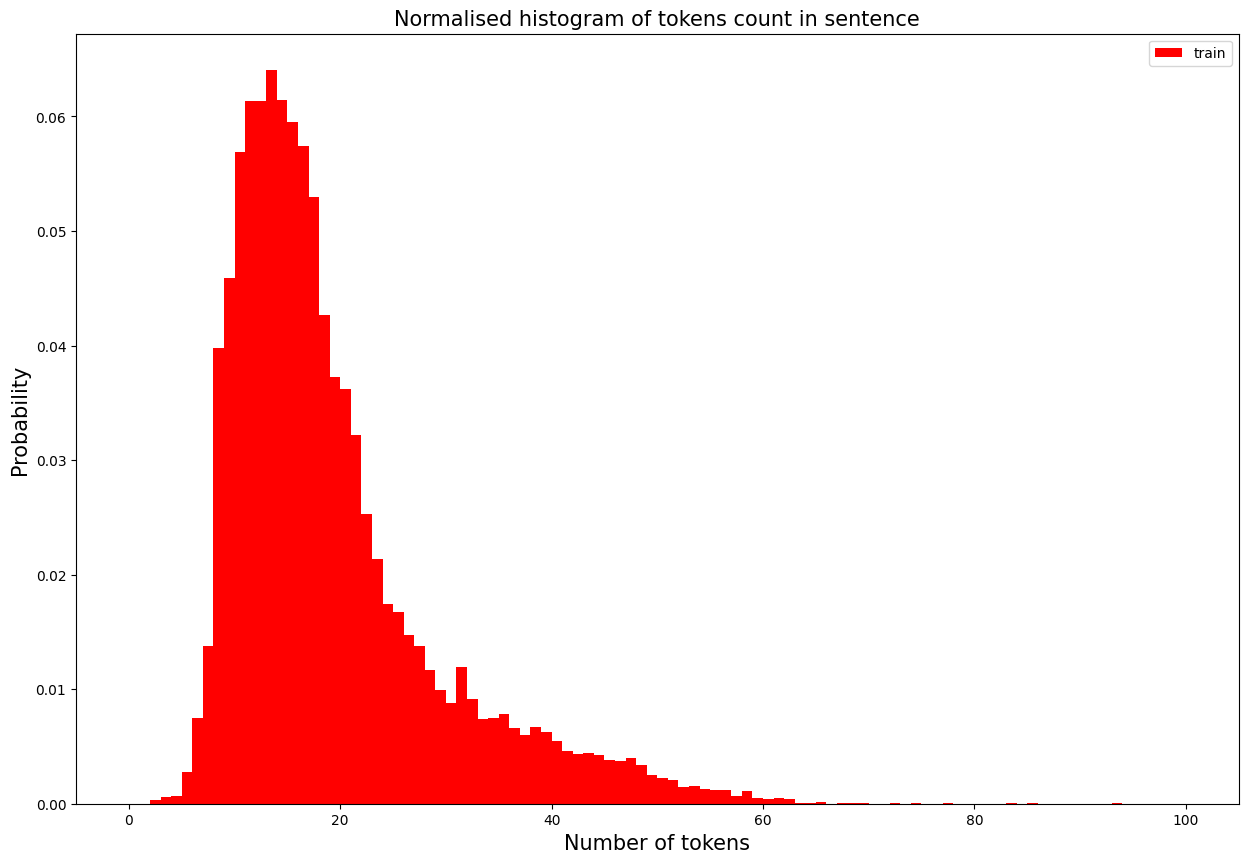

In [29]:
plt.figure(figsize=(15, 10))
plt.hist(train_bert_token_cased_counts, bins=100, range=[0, 100], facecolor='r', density=True, label='train')
plt.title('Normalised histogram of tokens count in sentence', fontsize=15)
plt.legend()
plt.xlabel('Number of tokens', fontsize=15)
plt.ylabel('Probability', fontsize=15)

In [31]:
print('문장 tokens 개수 최대 값: {}'.format(np.max(train_bert_token_cased_counts)))
print('문장 tokens 개수 평균 값: {:.2f}'.format(np.mean(train_bert_token_cased_counts)))
print('문장 tokens 개수 표준편차: {:.2f}'.format(np.std(train_bert_token_cased_counts)))
print('문장 tokens 개수 중간 값: {}'.format(np.median(train_bert_token_cased_counts)))
print('문장 tokens 개수 제1사분위: {}'.format(np.percentile(train_bert_token_cased_counts, 25)))
print('문장 tokens 개수 제3사분위: {}'.format(np.percentile(train_bert_token_cased_counts, 75)))
print('문장 tokens 개수 99 퍼센트: {}'.format(np.percentile(train_bert_token_cased_counts, 99)))

문장 tokens 개수 최대 값: 102
문장 tokens 개수 평균 값: 18.74
문장 tokens 개수 표준편차: 10.12
문장 tokens 개수 중간 값: 16.0
문장 tokens 개수 제1사분위: 12.0
문장 tokens 개수 제3사분위: 22.0
문장 tokens 개수 99 퍼센트: 53.0


{'whiskers': [<matplotlib.lines.Line2D at 0x7d7ccd6511b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7d7ccd651720>,
 'boxes': [<matplotlib.lines.Line2D at 0x7d7ccd650f10>],
 'medians': [<matplotlib.lines.Line2D at 0x7d7ccd651c60>],
 'fliers': [<matplotlib.lines.Line2D at 0x7d7ccd6521a0>],
 'means': [<matplotlib.lines.Line2D at 0x7d7ccd651f00>]}

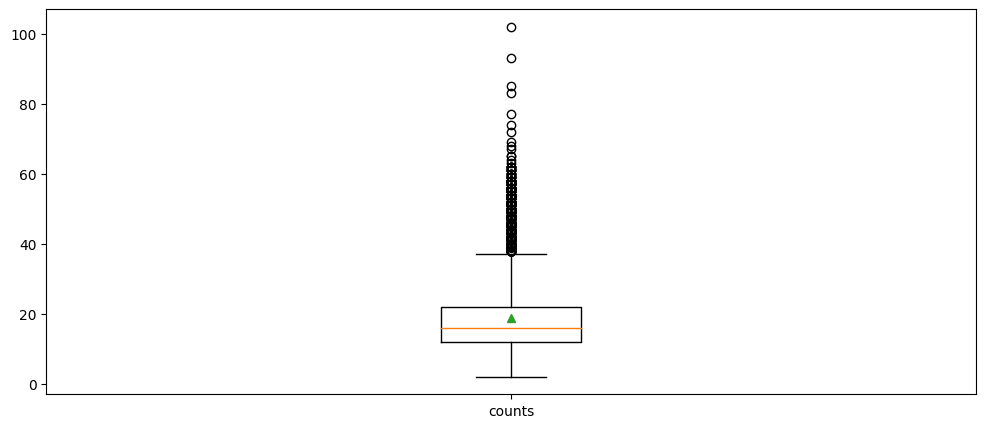

In [32]:
plt.figure(figsize=(12,5))

plt.boxplot(train_bert_token_cased_counts, labels=['counts'], showmeans=True)

<Axes: >

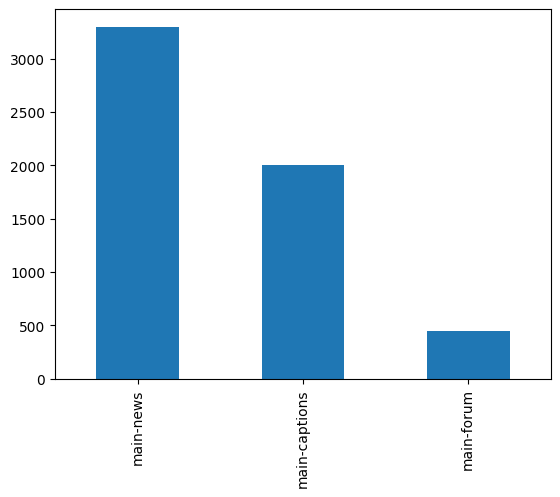

In [38]:
train_data.genre.value_counts().plot(kind='bar')

<Axes: >

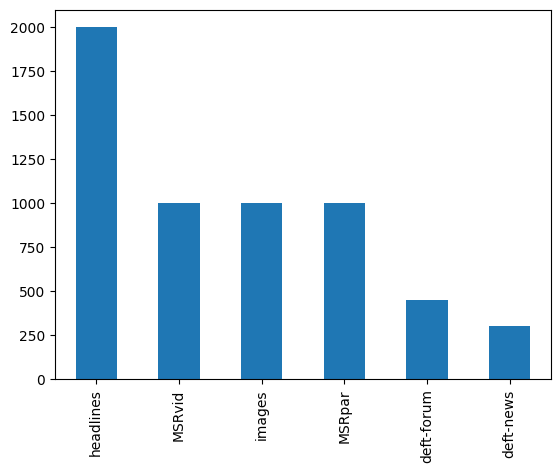

In [39]:
train_data.filename.value_counts().plot(kind='bar')

<Axes: >

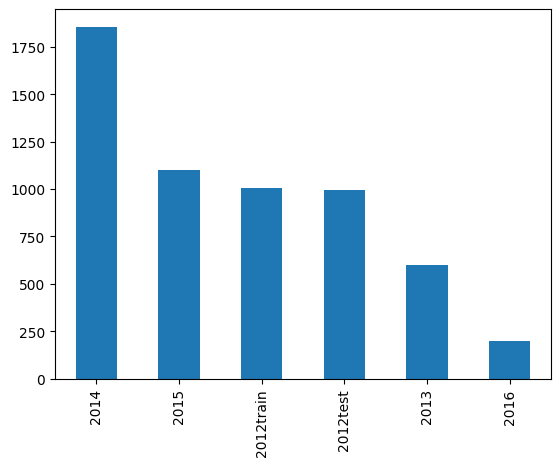

In [41]:
train_data.year.value_counts().plot(kind='bar')

<Axes: >

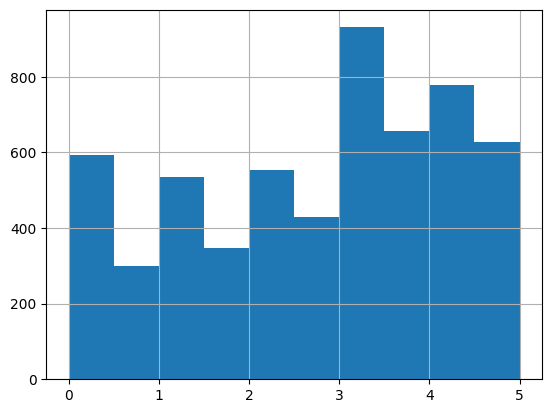

In [40]:
train_data.score.hist()

In [8]:
train_sts_df = os.path.join(data_path, 'korSTS', 'sts-train.tsv')
dev_sts_df = os.path.join(data_path, 'korSTS', 'sts-dev.tsv')

train_datas = pd.read_csv(train_sts_df, header=0, delimiter = '\t', quoting = 3)
dev_datas = pd.read_csv(dev_sts_df, header=0, delimiter = '\t', quoting = 3)

print("Total # dataset: train - {}, dev - {}".format(len(train_datas), len(dev_datas)))

Total # dataset: train - 5749, dev - 1500


In [21]:
def bert_tokenizer_v2(sent1, sent2, MAX_LEN):

    encoded_dict = tokenizer.encode_plus( text = sent1,
        text_pair = sent2,
        add_special_tokens = True, # ADD '[CLS] and '[SEP]'
        max_length = MAX_LEN, # Pad & truncate all sentences,
        padding = 'max_length',
        return_attention_mask = True, # Construct attn, masks.
        truncation = True
    )

    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask']
    token_type_id = encoded_dict['token_type_ids']

    return input_id, attention_mask, token_type_id #값들이 리스트로 반환된다.

def clean_text(sent):
    sent_clean = re.sub("[^a-zA-z0-9ㄱ-ㅣ가-힣\\s]", "", sent)
    return sent_clean

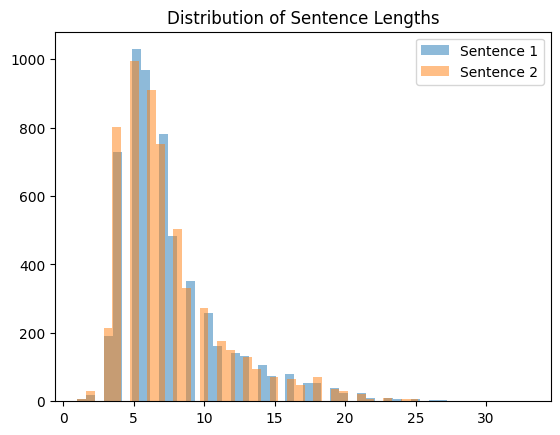

In [10]:
train_datas['sent1_len'] = train_datas['sentence1'].apply(lambda x: len(x.split()))
train_datas['sent2_len'] = train_datas['sentence2'].apply(lambda x: len(x.split()))

plt.hist(train_datas['sent1_len'], bins=50, alpha=0.5, label='Sentence 1')
plt.hist(train_datas['sent2_len'], bins=50, alpha=0.5, label='Sentence 2')
plt.legend()
plt.title('Distribution of Sentence Lengths')
plt.show()

In [22]:
input_ids = []
attention_masks = []
token_type_ids = []
data_labels = []


for sent1, sent2, score in train_datas[['sentence1', 'sentence2', 'score']].values:
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(clean_text(sent1), clean_text(sent2), 24*2)
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(score)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass


train_input_ids = np.array(input_ids, dtype=int)
train_attention_masks = np.array(attention_masks, dtype=int)
train_type_ids = np.array(token_type_ids, dtype=int)
train_inputs = (train_input_ids, train_attention_masks, train_type_ids)
train_data_labels = np.array(data_labels)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

In [24]:
print(train_data_labels)
print(train_input_ids)
print(train_attention_masks)
print(train_type_ids)
print(train_inputs)

[5.  3.8 3.8 ... 0.  0.  0. ]
[[  101  9379 25549 ...     0     0     0]
 [  101  9954 76854 ...     0     0     0]
 [  101  9954 76854 ...     0     0     0]
 ...
 [  101  9318 56645 ...     0     0     0]
 [  101 45397  9640 ...     0     0     0]
 [  101  9935 90833 ...     0     0     0]]
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(array([[  101,  9379, 25549, ...,     0,     0,     0],
       [  101,  9954, 76854, ...,     0,     0,     0],
       [  101,  9954, 76854, ...,     0,     0,     0],
       ...,
       [  101,  9318, 56645, ...,     0,     0,     0],
       [  101, 45397,  9640, ...,     0,     0,     0],
       [  101,  9935, 90833, ...,     0,     0,     0]]), array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       

In [25]:
# Dev 데이터 처리
input_ids = []
attention_masks = []
token_type_ids = []
data_labels = []


for sent1, sent2, score in dev_datas[['sentence1', 'sentence2', 'score']].values:
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(clean_text(sent1), clean_text(sent2), 24*2)
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(score)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass

dev_input_ids = np.array(input_ids, dtype=int)
dev_attention_masks = np.array(attention_masks, dtype=int)
dev_type_ids = np.array(token_type_ids, dtype=int)
dev_inputs = (dev_input_ids, dev_attention_masks, dev_type_ids)
dev_data_labels = np.array(data_labels)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

In [26]:
class TFBertRegressor(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertRegressor, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.num_class = num_class
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.regressor = tf.keras.layers.Dense(
            self.num_class,
            kernel_initializer=tf.keras.initializers.TruncatedNormal(
                self.bert.config.initializer_range
                ),
            name='regressor',
            )

    def call(self, inputs, attention_masks=None, token_type_ids=None, training=False):

        outputs = self.bert(
            inputs, attention_mask=attention_mask, token_type_ids=token_type_ids
        )
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.regressor(pooled_output)

        return logits


In [27]:
regression_model = TFBertRegressor(model_name='bert-base-multilingual-cased',
                                   dir_path='bert_ckpt',
                                   num_class=1)

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [28]:
class PearsonCorrelationMetric(tf.keras.metrics.Metric):
    def __init__(self, name="pearson_correlation", **kwargs):
        super(PearsonCorrelationMetric, self).__init__(name=name, **kwargs)
        self.y_true_list=[]
        self.y_pred_list=[]

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, shape=[-1])
        y_pred = tf.reshape(y_pred, shape=[-1])
        self.y_true_list.append(y_true)
        self.y_pred_list.append(y_pred)

    def result(self):
        y_true = tf.concat(self.y_true_list, -1)
        y_pred = tf.concat(self.y_pred_list, -1)
        pearson_correlation = self.pearson(y_true, y_pred)

        return pearson_correlation

    def reset_states(self):
        self.y_true_list = []
        self.y_pred_list = []

    def pearson(self, true, pred):
        m_true = tf.reduce_mean(true)
        m_pred = tf.reduce_mean(pred)
        m_true, m_pred = true-m_true, pred-m_pred
        num = tf.reduce_sum(tf.multiply(m_true, m_pred))
        den = tf.sqrt(tf.multiply(tf.reduce_sum(tf.square(m_true)), tf.reduce_sum(tf.square(m_pred)))) + 1e-12
        return num / den

In [29]:
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.MeanSquaredError()
metric = PearsonCorrelationMetric()
regression_model.compile(optimizer=optimizer, loss=loss, metrics=[metric], run_eagerly=True)

In [30]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [38]:
model_name = "tf2_BERT_KorSTS"

earlystop_callback = EarlyStopping(
    monitor="val_pearson_correlation", min_delta=0.0001, patience=2, mode="max"
)

checkpoint_path = os.path.join(data_path, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_pearson_correlation', verbose=1, save_best_only=True, save_weights_only=True, mode='max'
)

history = regression_model.fit(train_inputs, train_data_labels, epochs=3,
                               validation_data = (dev_inputs, dev_data_labels),
                               batch_size=4, callbacks=[earlystop_callback, cp_callback])

print(history.history)

/content/drive/MyDrive/toy_project/Bert/tf2_BERT_KorSTS -- Folder already exists 



InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
model.save('/content/drive/MyDrive/YAI/STSmodel.h5')

In [93]:
test_sts_df = os.path.join(data_path, 'korSTS', 'sts-test.tsv')

test_datas = pd.read_csv(test_sts_df, header=0, delimiter = '\t', quoting = 3)
test_datas.head()

# Test 데이터 처리
input_ids = []
attention_masks = []
token_type_ids = []
data_labels = []


for sent1, sent2, score in test_datas[['sentence1', 'sentence2', 'score']].values:
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(clean_text(sent1), clean_text(sent2), 24*2)
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(score)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass

test_input_ids = np.array(input_ids, dtype=int)
test_attention_masks = np.array(attention_masks, dtype=int)
test_type_ids = np.array(token_type_ids, dtype=int)
test_inputs = (test_input_ids, test_attention_masks, test_type_ids)
test_data_labels = np.array(data_labels)

name 'MAX_LEN' is not defined
한 소녀가 머리를 스타일링하고 있다. 한 소녀가 머리를 빗고 있다.
name 'MAX_LEN' is not defined
한 무리의 남자들이 해변에서 축구를 한다. 한 무리의 소년들이 해변에서 축구를 하고 있다.
name 'MAX_LEN' is not defined
한 여성이 다른 여성의 발목을 재고 있다. 한 여자는 다른 여자의 발목을 측정한다.
name 'MAX_LEN' is not defined
한 남자가 오이를 자르고 있다. 한 남자가 오이를 자르고 있다.
name 'MAX_LEN' is not defined
한 남자가 하프를 연주하고 있다. 한 남자가 키보드를 연주하고 있다.
name 'MAX_LEN' is not defined
한 여자가 양파를 자르고 있다. 한 여자가 두부를 자르고 있다.
name 'MAX_LEN' is not defined
한 남자가 전기 자전거를 타고 있다. 한 남자가 자전거를 타고 있다.
name 'MAX_LEN' is not defined
한 남자가 드럼을 치고 있다. 남자가 기타를 치고 있다.
name 'MAX_LEN' is not defined
한 남자가 기타를 치고 있다. 한 여성이 기타를 연주하고 있다.
name 'MAX_LEN' is not defined
한 남자가 기타를 치고 있다. 한 남자가 트럼펫을 연주하고 있다.
name 'MAX_LEN' is not defined
한 남자가 기타를 치고 있다. 한 남자가 트럼펫을 연주하고 있다.
name 'MAX_LEN' is not defined
한 남자가 양파를 자르고 있다. 한 남자가 양파를 잘랐다.
name 'MAX_LEN' is not defined
한 남자가 자전거를 타고 있다. 한 남자가 말하고 있다.
name 'MAX_LEN' is not defined
한 남자가 생선을 썰어 열고 있다. 한 남자가 생선을 자르고 있다.
name 'MAX_LEN' is not defined
한 남자가 토마토를 자르고 있다. 

In [34]:
regression_model.load_weights(checkpoint_path)

results = regression_model.evaluate(test_inputs, test_data_labels, batch_size=512)
print("test loss, test pearson correlation: ", results)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/content/drive/MyDrive/toy_project/Bert/tf2_BERT_KorSTS/weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)